In [ ]:
# Import required libraries
import os
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
import json

# Set path to your Kaggle JSON file
kaggle_json_path = r"C:\Users\Admin\.kaggle\kaggle.json"  # Update this path

# Load Kaggle credentials manually from kaggle.json
with open(kaggle_json_path, 'r') as f:
    kaggle_credentials = json.load(f)

# Set Kaggle environment variables for the API to use
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

# Initialize and authenticate the Kaggle API
api = KaggleApi()
api.authenticate()
print("Kaggle API authenticated successfully!")

# Correct dataset path
dataset = 'paultimothymooney/breast-histopathology-images'

# Download the dataset
try:
    api.dataset_download_files(dataset, path='./', unzip=True)
    print(f"Dataset downloaded successfully!")
except Exception as e:
    print(f"Error during download: {e}")


# Unzip the dataset
downloaded_file_path = os.path.join('.', file_name)
if os.path.exists(downloaded_file_path):
    with zipfile.ZipFile(downloaded_file_path, 'r') as zip_ref:
        zip_ref.extractall("data")
    print("Dataset unzipped successfully!")


Kaggle API authenticated successfully!
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images


In [5]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Set the path to the dataset directory (use raw string 'r' to avoid issues with backslashes)
data_dir = r'C:\Users\Admin\Jupyter Files\Dataset\IDC_regular_ps50_idx5\16532'

# Define image size and categories (malignant = 1, benign = 0)
IMG_SIZE = 50
categories = ["0", "1"]

# Prepare the dataset
def load_data(data_dir):
    data = []
    for category in categories:
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)  # 0 for benign, 1 for malignant
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([img_resized, class_num])
            except Exception as e:
                pass  # Ignore any errors during loading
    return data

# Load the data
data = load_data(data_dir)
print(f"Total images loaded: {len(data)}")

# Shuffle the data
import random
random.shuffle(data)

# Split features and labels
X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

# Convert to NumPy arrays and normalize the images
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X = X / 255.0  # Normalize pixel values (0-1)
y = np.array(y)

# One-hot encoding of labels (2 classes: benign = 0, malignant = 1)
y = to_categorical(y, 2)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print data set sizes
print(f"Training set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")
print(f"Test set: {len(X_test)} images")


Total images loaded: 467
Training set: 326 images
Validation set: 70 images
Test set: 71 images


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential()

# Input layer
model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))  # This is where you specify the input shape

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten the output
model.add(layers.Flatten())

# Fully connected layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))  # Two classes (benign and malignant)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 9, 9, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 355,778 (1.36 MB)

 Trainable params: 355,778 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.6532 - loss: 0.6320 - val_accuracy: 0.7000 - val_loss: 0.6063
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7320 - loss: 0.5765 - val_accuracy: 0.7000 - val_loss: 0.6468
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7498 - loss: 0.5964 - val_accuracy: 0.7000 - val_loss: 0.6215
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7170 - loss: 0.5931 - val_accuracy: 0.7000 - val_loss: 0.6187
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7496 - loss: 0.5595 - val_accuracy: 0.7000 - val_loss: 0.5846
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6880 - loss: 0.5753 - val_accuracy: 0.7000 - val_loss: 0.5308
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7457 - loss: 0.5022 - val_accuracy: 0.7000 - val_loss: 0.4885
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.7338 - loss: 0.4560 - val_accuracy: 0.7000 - 

In [9]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7928 - loss: 0.5727
Test Accuracy: 78.87%


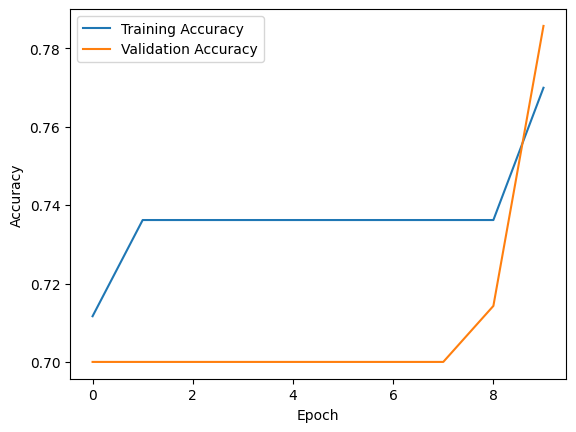

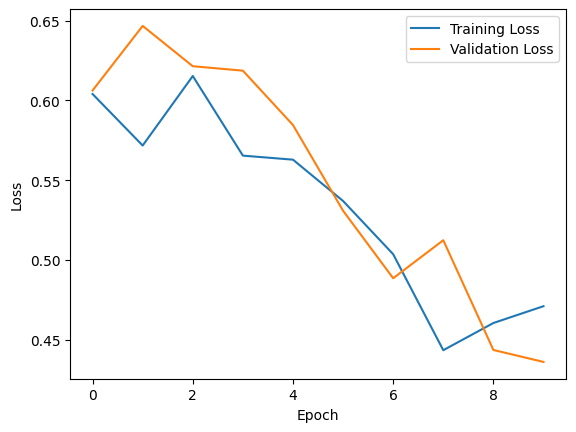

In [10]:
import matplotlib.pyplot as plt

# Plot training accuracy and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model (assuming you already have the model architecture defined)
model = models.Sequential()
model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

# Create a new optimizer
optimizer = tf.keras.optimizers.Adam()

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Save the model using the new Keras format
model.save('my_model.keras')

print("Model trained and saved successfully.")


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.6930 - loss: 0.6458 - val_accuracy: 0.7000 - val_loss: 0.6402
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7687 - loss: 0.5275 - val_accuracy: 0.7000 - val_loss: 0.6337
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7101 - loss: 0.6094 - val_accuracy: 0.7000 - val_loss: 0.6389
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7401 - loss: 0.5706 - val_accuracy: 0.7000 - val_loss: 0.5830
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.7558 - loss: 0.5464 - val_accuracy: 0.7000 - val_loss: 0.5627
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7468 - loss: 0.5108 - val_accuracy: 0.7000 - val_loss: 0.6581
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7456 - loss: 0.5896 - val_accuracy: 0.7000 - val_loss: 0.5482
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7463 - loss: 0.4893 - val_accuracy: 0.7000 - 

In [24]:
import cv2
import numpy as np

# Set the path to the new image
image_path = r'C:\Users\Admin\Jupyter Files\Dataset\16533\0\16533_idx5_x151_y1101_class0.png'  # Update this path with the actual image file path

# Predict on a new image
img = cv2.imread(image_path)

# Check if the image was loaded successfully
if img is None:
    print(f"Error: Could not load image at {image_path}. Please check the path.")
else:
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_array = np.array(img_resized).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    img_array = img_array / 255.0  # Normalize pixel values

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Predicted class: [1]
